# Final Assignment TBIR 2016
For the presentation of the final assignment of TBIR 2016, we choose to do use the wordembedding as our best working retrieval model.

This is a seperate notebook, just to make sure the links are right an no non-relevant info per model is shown.

### Set-up and load modules

In [93]:
# Load in Python modules
import os, re
import pandas as pd
from numpy import dot, sum
from gensim import matutils, models

# Set up logger that logs (works in jupyter 3!) in console and outputs in file
import logging
logger = logging.getLogger()
fhandler = logging.FileHandler(filename='part_II_logs.log', mode='a')
formatter = logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')
fhandler.setFormatter(formatter)
logger.addHandler(fhandler)
logger.setLevel(logging.DEBUG)

# Variables
query_list = 'data/queries_val_parsed.txt'
target_collection = 'data/target_collection_parsed.txt'
embedding_model = 'data/GoogleNews-vectors-negative300.bin.gz'
stopwords_list = 'data/stopwordlist.txt'
output_file = 'data/output2.txt'

### Load Embedding Model

In [30]:
# Load Googles' pre-trained Word2Vec vector set
# Note: This will take a lot of memory and can take a while.
# Note II: Gensim will automatically normalize the model if loaded like this, so init_sims is not needed
w2v_model = models.Word2Vec.load_word2vec_format(embedding_model, binary=True)


INFO:gensim.models.word2vec:loading projection weights from data/GoogleNews-vectors-negative300.bin.gz
INFO:gensim.models.word2vec:loaded (3000000L, 300L) matrix from data/GoogleNews-vectors-negative300.bin.gz
INFO:gensim.models.word2vec:precomputing L2-norms of word weight vectors


### Load Helper Functions

In [31]:
# Load in a stopword list from
# Source: http://www.lextek.com/manuals/onix/stopwords2.html
stopwords = []
with open(stopwords_list, 'r') as f:
    lines = ''.join(f.readlines())
    stopwords = [x for x in lines.split('\n')[2:]]


In [84]:
# Clean input because the wordmodels can not contain every possible combination words and signs
def clean_input(text, stopwords):
    # lowecase and remove linebreaks
    text = text.lower().rstrip()
    # Remove stopwords
    text = ' '.join([word for word in text.split() if word not in stopwords])
    # Remove punctuation
    text = re.sub('[!@#$:;%&?,_\.\'\`\"\\\/\(\)\[\]]', ' ', text)
    text = re.sub('[\-]+', '-', text)
    # Remove sole numbers, dashes or extra spaces
    text = re.sub('[\s][\-]+[\s]', '', text)
    text = re.sub('[0-9]+', '', text)
    text = re.sub('[\s]+', ' ', text)
    # British to American English - at this moment still hardcoded due to lack of library
    text = text.replace('grey', 'gray')
    text = text.replace('colour', 'color')
    text = text.replace('tyre', 'tire')
    text = text.replace('centre', 'center')
    text = text.replace('theatre', 'theater')
    text = text.replace('jewellery','jewelry')
    text = text.replace('aeroplane', 'plane')
    text = text.replace('harbour', 'harbor')
    text = text.replace('moustache','mustache')
    text = text.replace(' axe', ' hatchet')
    text = text.replace('armour', 'armor')
    text = text.replace('stylised', 'stylized')
    text = text.replace('stylise', 'stylize')
    text = text.replace('organise', 'organize')
    text = text.replace('plough', 'plow')
    text = text.replace('neighbourhood', 'neighborhood')
    text = text.replace('vapour', 'vapor')
    text = text.replace('customised', 'customized')
    # some manual fixes of lemmatizing
    text = text.replace('watersid ', 'waterside ')
    text = text.replace('figur ', 'figure ')
    text = text.replace(' graz ', ' graze ')
    text = text.replace('sofasettee', 'sofa settee')
    text = text.replace('dilapidate', 'dilapidated')
    text = text.replace('travelling', 'travel')
    text = text.replace('motorbik ', 'motorbike ')
    text = text.replace('dishevel ', 'disheveled ')
    text = text.replace('bowlin ', 'bowling ')
    text = text.replace('overshirts', 'overshirt')
    text = text.replace('labcoat', 'lab coat')
    text = text.replace('labelled', 'label')
    text = ' '.join([word for word in text.split() if word not in stopwords])
    return text


In [33]:
# Translate text to avg vector
def sentence_to_vector(model, sentence):
    v1 = []
    for word in sentence.split(' '):
        try:
            v1.append(model[word])
        except:
            if "-" in word: # attempt dash removing or replacing with space
                try:
                     v1.append(model[word.replace("-", "")])
                except:
                    try:
                        v1.append(model[word.split("-")[0]])
                        v1.append(model[word.split("-")[1]])
                    except:
                        print 'word not in model:', word
                        continue
            else:
                print 'word not in model:', word
                continue
    # return unitvector
    return matutils.unitvec(sum(v1,axis=0))


In [34]:
# Text file parser
# Returns a dictionary with imageid - text in lowercase without stopwords or punctuation
def text_file_parser(filename, stopwords, model):
    corpus = dict()
    #corpus = pd.DataFrame(columns=('id', 'imageid', 'vec'))
    with open(filename) as f:
        #next(f) # skip first line with the headings
        for doc in f:
            '''
            # Normal:
            doc_parts = doc.split('\t')
            doc_parts[2] = clean_input(doc_parts[2])
            doc_parts.append(sentence_to_vector(model, doc_parts[2]))
            corpus[doc_parts[0]] = doc_parts
            
            # If use of parsed
            '''
            # Split on spaces
            doc_parts = doc.split(" ", 1)
            # If first part is the ID (needed for the queries file)
            if(len(doc_parts[0]) < 6):
                doc_parts = doc.split(" ", 2)
                doc_parts.pop(0)
            # Clean the caption text (remove puctuation etc)
            doc_parts[1] = clean_input(doc_parts[1], stopwords)
            # Add the vector of the caption to the array
            doc_parts.append(sentence_to_vector(model, doc_parts[1]))
            # add the array (or row) to an array
            corpus[len(corpus) + 1] = doc_parts

    # Transform to dataframe
    df = pd.DataFrame.from_dict(corpus, orient='index')
    df = df.reset_index()
    df.columns = ['index', 'img_id', 'caption', 'vec']
    return df


In [35]:
# function to calculate the similarity between 2 documents
def similarity(v1, v2):
    # Because the vectors have been normalized, the dotproduct is similar to calculating the cosine simularity
    return dot(v1, v2)


### Read in data and calculate similarity

In [100]:
# images file to docs dict
print 'Parsing documents'
training_docs = text_file_parser(target_collection, stopwords, w2v_model)
print 'Parsing queries'
queries = text_file_parser(query_list, stopwords, w2v_model)

# Preview
queries

Parsing documents
word not in model: seethrough
word not in model: covington
word not in model: figur
word not in model: solvaten
word not in model: lightyear
word not in model: black-and-white
word not in model: streetperson
word not in model: out-of-focus
word not in model: adana
word not in model: soundmixer
word not in model: tirol
word not in model: hyperthermal
word not in model: kustwacht
word not in model: tug-of-war
word not in model: black-and-white
word not in model: black-and-white
word not in model: latifah
word not in model: shepparton
word not in model: black-and-white
word not in model: relaxingly
word not in model: black-and-white
word not in model: jetplane
word not in model: piza
word not in model: wyclef
word not in model: parke
word not in model: edwardian
word not in model: black-and-white
word not in model: black-and
word not in model: black-and-white
word not in model: antagonise
word not in model: selfie
word not in model: black-and-white
word not in model: bla

,index,img_id,caption,vec
0,1,XBZPztvt67qkMUdI,man white shirt sit table cut meat plate front...,"[0.037023062002, 0.0189000459091, 0.0207429838..."
1,2,PaqtOaYmQmXkqW2i,woman red dress posing hatchet,"[0.0647384797321, -0.00280874662717, 0.0190497..."
2,3,IPcFtNL-7EQ6Z0yu,soccer play stand soccer ball front,"[0.00913737650506, 0.0457835407256, 0.07424217..."
3,4,IMAD0sq2Fz7HpSgX,white yellow train track,"[-0.0223426769541, 0.0784277429118, 0.04782966..."
4,5,-gqRDDfPZTGlCfJa,view tall building city,"[-0.0118529041814, 0.0563774749778, 0.01534611..."
5,6,xsrYb57vl4qiMLDG,hand pick flower vine,"[0.0556772009794, 0.0733344995993, -0.07167356..."
6,7,BCjxgJlQ3TD5T8ST,picture army ready sail,"[0.0596367267377, 0.17693899886, -0.0339552790..."
7,8,LGxwsl9CtRQ8wW3Y,brick roof house picture,"[0.0435841136776, 0.0197629527588, -0.01897175..."
8,9,9LtOvyiygFYoxU8S,man clean mess street,"[0.0964928784341, 0.1010682429, 0.050989103614..."
9,10,8usTLD-Wg5EHCShk,group kid play playground accompany adult,"[0.0110731805617, 0.00217351814068, 0.02269845..."


In [ ]:
# Create outputfile if not already exists
if not os.path.exists(output_file):
    open(output_file, 'w').close()

# Create a results dataframe that will contain the MAP and average recall for all run queries
results = pd.DataFrame(index=range(0,1000), columns=['map', 'recall'])
results['map'] = 0.0
results['recall'] = 0.0

# Calculate similarity
print "Calculating precision and recall"
for i,r in queries.iterrows():
    print "Processing query", i # Print the current query number
    
    rdoc = training_docs
    rdoc["sim"] = 0.0
    
    # Calculate similarity per vector document
    for index, row in rdoc.iterrows():
        sim = similarity(r['vec'], row['vec'])
        rdoc.set_value(index, "sim", sim)
    
    # order by similarity and get top 1000 results
    rdoc = rdoc.sort_values(by=['sim'], ascending=[0])
    rdoc = rdoc[:1000]
    rdoc = rdoc.reset_index() # Current indexes in index column and new ordered index from 0 to N

    # Get total amount of images that should be found
    total_to_find = float(len(training_docs[training_docs.img_id == r['img_id']]))
    total_found = 0.0
    current_avg_precision = 0.0
    
    # Iterare over top 1000 found documents
    for index,row in rdoc.iterrows():
        if row['img_id'] == r['img_id']:
            total_found = total_found + 1.0
            
        # Append values to dataframe for precision-recall curve
        current_avg_precision = current_avg_precision + float(total_found/float(index + 1.0))
        curr_results = results.loc[100]
        results.set_value(index, "recall", float(curr_results['recall']) + float(total_found/total_to_find))
        results.set_value(index, "map", float(curr_results['map']) + float(current_avg_precision/float(index + 1.0)))
        
        # Append to the output file
        with open(output_file,'a') as f:
            # Output in the file is structured as:
            # query_id 0 sent_id 0 similarity_score 0
            f.write(str(r['index'])+' 0 '+str(row['index'])+' 0 '+str(row['sim'])+" 0\n")
    
    # Reduce results rows to averages
    results['recall'] = results.apply((lambda row: float(float(row['recall'])/1000.0)), axis=1)
    results['map'] = results.apply((lambda row: float(float(row['map'])/1000.0)), axis=1)


Calculating precision and recall
Processing query 0
Processing query 1
Processing query 2
Processing query 3
Processing query 4
Processing query 5
Processing query 6
Processing query 7
Processing query 8
Processing query 9
Processing query 10
Processing query 11
Processing query 12
Processing query 13
Processing query 14
Processing query 15
Processing query 16
Processing query 17
Processing query 18
Processing query 19
Processing query 20
Processing query 21
Processing query 22
Processing query 23
Processing query 24
Processing query 25
Processing query

In [96]:
print "Displaying results:"

print "--"
print "MAP for best 10:", results.loc[9]['map']
print "MAP for best 100:", results.loc[99]['map']
print "MAP for best 250:", results.loc[249]['map']
print "MAP for best 500:", results.loc[499]['map']

print "AVG recall for best 10", results.loc[9]['recall']
print "AVG recall for best 100", results.loc[99]['recall']
print "AVG recall for best 250", results.loc[249]['recall']
print "AVG recall for best 500", results.loc[499]['recall']
print "--"

# print results
print results


Displaying results:
--
MAP for best 10: 0.0
MAP for best 100: 0.0
MAP for best 250: 0.00302054035951
MAP for best 500: 0.00427886290199
AVG recall for best 10 0.0
AVG recall for best 100 0.0
AVG recall for best 250 0.00025
AVG recall for best 500 0.00025
--
          map   recall
0    0.000000  0.00000
1    0.000000  0.00000
2    0.000000  0.00000
3    0.000000  0.00000
4    0.000000  0.00000
5    0.000000  0.00000
6    0.000000  0.00000
7    0.000000  0.00000
8    0.000000  0.00000
9    0.000000  0.00000
10   0.000000  0.00000
11   0.000000  0.00000
12   0.000000  0.00000
13   0.000000  0.00000
14   0.000000  0.00000
15   0.000000  0.00000
16   0.000000  0.00000
17   0.000000  0.00000
18   0.000000  0.00000
19   0.000000  0.00000
20   0.000000  0.00000
21   0.000000  0.00000
22   0.000000  0.00000
23   0.000000  0.00000
24   0.000000  0.00000
25   0.000000  0.00000
26   0.000000  0.00000
27   0.000000  0.00000
28   0.000000  0.00000
29   0.000000  0.00000
..        ...      ...
970  0

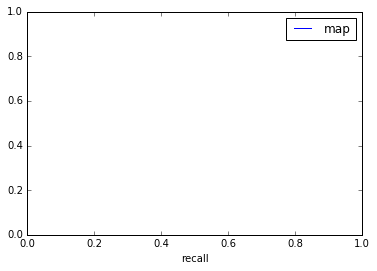

In [98]:
%matplotlib inline
import matplotlib.pyplot as plt

# Sort by recall
#df = df.sort_values(by=['recall'], ascending=[1])

# Show and save chart
qx = results.plot(x='recall', y='map')
qx.set_xlim([0,1])
qx.set_ylim([0,1])
fig = qx.get_figure()
fig.savefig('results/part2_embedding_precision-recall.png')